In [ ]:
#!pip install transformers accelerate bitsandbytes datasets matplotlib --quiet

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
import math
import re
import matplotlib.pyplot as plt
import pandas as pd

from copy import deepcopy
from torch.utils.data import DataLoader, Dataset, TensorDataset
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "Qwen/Qwen3-0.6B"

tokenizer = AutoTokenizer.from_pretrained(model_name)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)
device = next(model.parameters()).device
print("Model loaded on:", device)

`torch_dtype` is deprecated! Use `dtype` instead!


Model loaded on: cuda:0


In [3]:
#fix seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [8]:
print("Loading MMLU and GSM8K subsets...")

mmlu = load_dataset("cais/mmlu", "all", split="test")
# We'll use the "test" split from a subset of subjects
mmlu_subjects = [
    "abstract_algebra",
    "high_school_physics",
    "college_chemistry",
    "high_school_computer_science"
]

mmlu_examples = []
#print(mmlu)
for subj in mmlu_subjects:
    ds = load_dataset("cais/mmlu", subj, split="test")
    #print(ds)

    num_ex = len(ds["question"])
    for idx in range(num_ex):
        # Normalize choices/options
        choices = ds["choices"][idx] 
        answer_idx = ds["answer"][idx]  

        # Only keep four-choice questions
        if len(choices) != 4:
            continue
    
        mmlu_examples.append({
            "question": ds["question"][idx],
            "choices": choices,
            "answer_idx": int(answer_idx),
        })

print("MMLU subset size:", len(mmlu_examples))
gsm8k = load_dataset("openai/gsm8k", "main", split="test")
k = max(1, min(int(0.1 * len(gsm8k)), 300))
idxs = random.sample(range(len(gsm8k)), k)
gsm8k_examples = [gsm8k[i] for i in idxs]
print("GSM8K subset size:", len(gsm8k_examples))
ppl_texts_mmlu = [ex["question"] for ex in mmlu_examples]
print("Perplexity texts mmlu:", len(ppl_texts_mmlu))
ppl_texts_gsm8k = [ex["question"] for ex in gsm8k_examples]
print("Perplexity texts gsm8k:", len(ppl_texts_gsm8k))

Loading MMLU and GSM8K subsets...
MMLU subset size: 451
GSM8K subset size: 131
Perplexity texts mmlu: 451
Perplexity texts gsm8k: 131


In [9]:
#evaluation Utilities
def compute_loglikelihood(model, tokenizer, prompt, continuation, max_length=512):
    model.eval()
    with torch.no_grad():
        full = prompt + continuation
        enc = tokenizer( full, return_tensors="pt", truncation=True, max_length=max_length).to(device)

        input_ids = enc["input_ids"]
        prompt_enc = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=max_length).to(device)
        prompt_len = prompt_enc["input_ids"].size(1)
        labels = input_ids.clone()
        labels[:, :prompt_len] = -100

        out = model(input_ids=input_ids, labels=labels)
        nll = out.loss.item() * (labels != -100).sum().item()
        return -nll


def evaluate_mmlu(model, tokenizer, mmlu_examples, max_length=512):
    correct = 0
    total = len(mmlu_examples)
    for ex in mmlu_examples:
        q = ex["question"]
        choices = ex["choices"]
        gold = ex["answer_idx"]
        prompt = (
            "Question: " + q + "\n" +
            "A. " + choices[0] + "\n" +
            "B. " + choices[1] + "\n" +
            "C. " + choices[2] + "\n" +
            "D. " + choices[3] + "\n" +
            "Answer:"
        )
        labels = [" A", " B", " C", " D"]
        scores = []
        for cand in labels:
            scores.append(compute_loglikelihood(model, tokenizer, prompt, cand, max_length))
        pred = max(range(4), key=lambda i: scores[i])
        if pred == gold:
            correct += 1
    return correct / total


number_pattern = re.compile(r"(-?\d+(\.\d+)?)")

def extract_last_number(text):
    matches = number_pattern.findall(text)
    if not matches:
        return None
    return matches[-1][0]


def generate_answer(model, tokenizer, question, max_new_tokens=64):
    prompt = "Question: " + question + "\nAnswer:"
    enc = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        out_ids = model.generate(
            **enc,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            temperature=0.0,
            pad_token_id=tokenizer.eos_token_id
        )
    text = tokenizer.decode(out_ids[0], skip_special_tokens=True)
    return text


def evaluate_gsm8k(model, tokenizer, gsm8k_examples, max_new_tokens=64):
    correct = 0
    total = len(gsm8k_examples)
    for ex in gsm8k_examples:
        q = ex["question"]
        gt_answer_full = ex["answer"]
        gt_num = extract_last_number(gt_answer_full)

        pred_full = generate_answer(model, tokenizer, q, max_new_tokens=max_new_tokens)
        pred_num = extract_last_number(pred_full)

        if gt_num is not None and pred_num is not None and gt_num == pred_num:
            correct += 1
    return correct / total


def compute_perplexity(model, tokenizer, texts, max_length=256, batch_size=4):
    model.eval()
    total_nll = 0.0
    total_tokens = 0
    dl = DataLoader(texts, batch_size=batch_size, shuffle=False)
    with torch.no_grad():
        for batch in dl:
            enc = tokenizer(
                batch,
                return_tensors="pt",
                truncation=True,
                max_length=max_length,
                padding=True,
            ).to(device)

            input_ids = enc["input_ids"]
            attention_mask = enc["attention_mask"]
            labels = input_ids.clone()
            labels[attention_mask == 0] = -100

            out = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = out.loss
            n_tokens = attention_mask.sum().item()
            total_nll += loss.item() * n_tokens
            total_tokens += n_tokens

    avg_nll = total_nll / total_tokens
    ppl = math.exp(avg_nll)
    return ppl


def eval_fn(model, tokenizer):
    print("  Evaluating MMLU...")
    acc_mmlu = evaluate_mmlu(model, tokenizer, mmlu_examples)
    print("  Evaluating GSM8K...")
    acc_gsm8k = evaluate_gsm8k(model, tokenizer, gsm8k_examples)
    print("  Evaluating perplexity...")
    ppl_mmlu = compute_perplexity(model, tokenizer, ppl_texts_mmlu)
    ppl_gsm8k = compute_perplexity(model, tokenizer, ppl_texts_gsm8k)
    print(f"  MMLU={acc_mmlu:.3f}, GSM8K={acc_gsm8k:.3f}, PPL MMLU={ppl_mmlu:.1f}, PPL GSM8K={ppl_gsm8k:.1f}")
    return acc_mmlu, acc_gsm8k, ppl_mmlu, ppl_gsm8k


In [10]:
#Baseline Evaluation
print("Baseline Qwen3-0.6B Evaluation")
baseline_acc_mmlu, baseline_acc_gsm8k, baseline_ppl_mmlu,  baseline_ppl_gsm8k = eval_fn(model, tokenizer)
baseline_results = {
    "model_type": ["baseline"],
    "acc_mmlu": [baseline_acc_mmlu],
    "acc_gsm8k": [baseline_acc_gsm8k],
    "ppl_mmlu": [baseline_ppl_mmlu],
    "ppl_gsm8k": [baseline_ppl_gsm8k],
}
df_baseline = pd.DataFrame(baseline_results)
df_baseline.to_csv("baseline_results.csv", index=False)
print(df_baseline)

Baseline Qwen3-0.6B Evaluation
  Evaluating MMLU...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


  Evaluating GSM8K...
  Evaluating perplexity...
  MMLU=0.322, GSM8K=0.053, PPL MMLU=11.4, PPL GSM8K=11.4
  model_type  acc_mmlu  acc_gsm8k   ppl_mmlu  ppl_gsm8k
0   baseline  0.321508   0.053435  11.397077     11.415


In [11]:
def disable_qwen_layer(layer):
    def bypass_forward(hidden_states, attention_mask=None, position_ids=None, **kwargs):
        return hidden_states
    layer.forward = bypass_forward

In [12]:
#Static Layer Removal
print("Static Layer Removal")
layers = model.model.layers
num_layers = len(layers)

results_static = []

for L in range(num_layers):
    print(f"Disabling layer {L}")
    m = deepcopy(model).to(device)
    disable_qwen_layer(m.model.layers[L])
    
    acc_mmlu, acc_gsm8k, ppl_mmlu, ppl_gsm8k = eval_fn(m, tokenizer)
    results_static.append([L, acc_mmlu, acc_gsm8k, ppl_mmlu, ppl_gsm8k])

df_static = pd.DataFrame(results_static, columns=["layer_idx", "acc_mmlu", "acc_gsm8k", "ppl_mmlu", "ppl_gsm8k"])
df_static.to_csv("static_layer_removal_results.csv", index=False)
print(df_static.head())

Static Layer Removal
Disabling layer 0
  Evaluating MMLU...
  Evaluating GSM8K...
  Evaluating perplexity...
  MMLU=0.220, GSM8K=0.000, PPL MMLU=1677073.4, PPL GSM8K=1857347.8
Disabling layer 1
  Evaluating MMLU...
  Evaluating GSM8K...
  Evaluating perplexity...
  MMLU=0.248, GSM8K=0.008, PPL MMLU=22982.0, PPL GSM8K=41726.7
Disabling layer 2
  Evaluating MMLU...
  Evaluating GSM8K...
  Evaluating perplexity...
  MMLU=0.202, GSM8K=0.015, PPL MMLU=4023.8, PPL GSM8K=4170.9
Disabling layer 3
  Evaluating MMLU...
  Evaluating GSM8K...
  Evaluating perplexity...
  MMLU=0.315, GSM8K=0.046, PPL MMLU=15.7, PPL GSM8K=14.6
Disabling layer 4
  Evaluating MMLU...
  Evaluating GSM8K...
  Evaluating perplexity...
  MMLU=0.268, GSM8K=0.031, PPL MMLU=15.6, PPL GSM8K=15.3
Disabling layer 5
  Evaluating MMLU...
  Evaluating GSM8K...
  Evaluating perplexity...
  MMLU=0.268, GSM8K=0.069, PPL MMLU=14.9, PPL GSM8K=14.6
Disabling layer 6
  Evaluating MMLU...
  Evaluating GSM8K...
  Evaluating perplexity...
 

Static Layer Removal
Disabling layer 0
  Evaluating MMLU...
  Evaluating GSM8K...
  Evaluating perplexity...
  MMLU=0.220, GSM8K=0.000, PPL MMLU=1677073.4, PPL GSM8K=1857347.8
Disabling layer 1
  Evaluating MMLU...
  Evaluating GSM8K...
  Evaluating perplexity...
  MMLU=0.248, GSM8K=0.008, PPL MMLU=22982.0, PPL GSM8K=41726.7
Disabling layer 2
  Evaluating MMLU...
  Evaluating GSM8K...
  Evaluating perplexity...
  MMLU=0.202, GSM8K=0.015, PPL MMLU=4023.8, PPL GSM8K=4170.9
Disabling layer 3
  Evaluating MMLU...
  Evaluating GSM8K...
  Evaluating perplexity...
  MMLU=0.315, GSM8K=0.046, PPL MMLU=15.7, PPL GSM8K=14.6
Disabling layer 4
  Evaluating MMLU...
  Evaluating GSM8K...
  Evaluating perplexity...
  MMLU=0.268, GSM8K=0.031, PPL MMLU=15.6, PPL GSM8K=15.3
Disabling layer 5
  Evaluating MMLU...
  Evaluating GSM8K...
  Evaluating perplexity...
  MMLU=0.268, GSM8K=0.069, PPL MMLU=14.9, PPL GSM8K=14.6
Disabling layer 6
  Evaluating MMLU...
  Evaluating GSM8K...
  Evaluating perplexity...
 

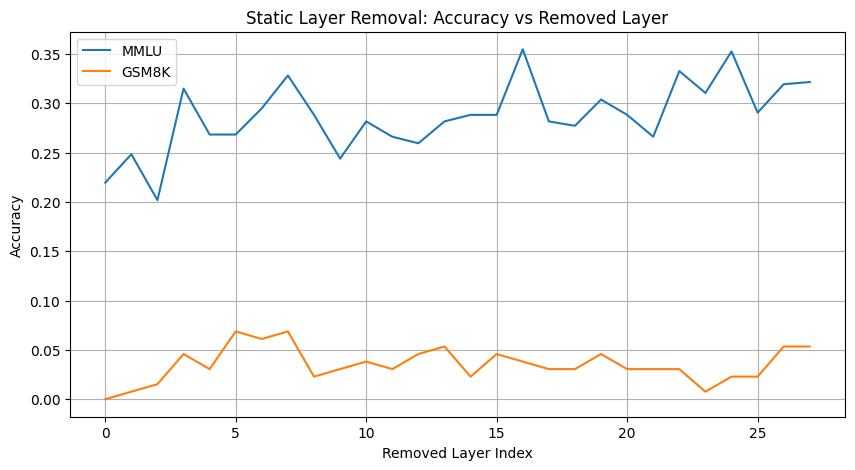

In [13]:
#Static Layer Removal
print("Static Layer Removal")
layers = model.model.layers
num_layers = len(layers)

results_static = []

for L in range(num_layers):
    print(f"Disabling layer {L}")
    m = deepcopy(model).to(device)
    disable_qwen_layer(m.model.layers[L])
    
    acc_mmlu, acc_gsm8k, ppl_mmlu, ppl_gsm8k = eval_fn(m, tokenizer)
    results_static.append([L, acc_mmlu, acc_gsm8k, ppl_mmlu, ppl_gsm8k])

df_static = pd.DataFrame(results_static, columns=["layer_idx", "acc_mmlu", "acc_gsm8k", "ppl_mmlu", "ppl_gsm8k"])
df_static.to_csv("static_layer_removal_results.csv", index=False)
print(df_static.head())

plt.figure(figsize=(10,5))
plt.plot(df_static["layer_idx"], df_static["acc_mmlu"], label="MMLU")
plt.plot(df_static["layer_idx"], df_static["acc_gsm8k"], label="GSM8K")
plt.xlabel("Removed Layer Index")
plt.ylabel("Accuracy")
plt.title("Static Layer Removal: Accuracy vs Removed Layer")
plt.legend()
plt.grid()
plt.show()

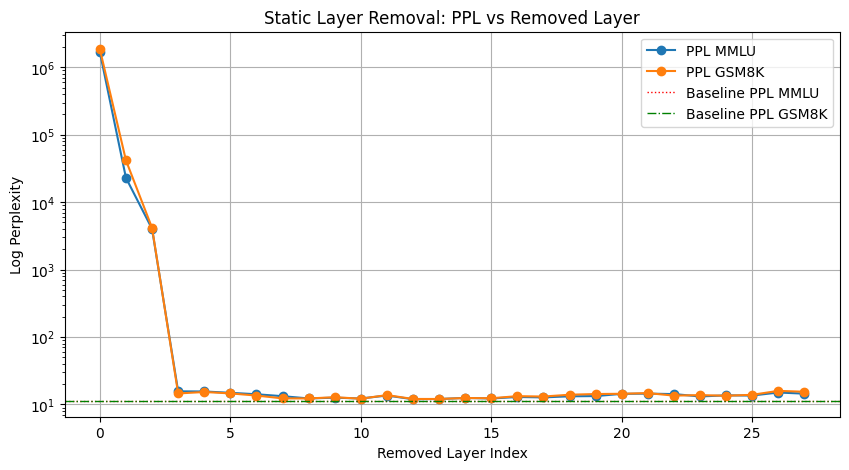

In [16]:
plt.figure(figsize=(10,5))
plt.yscale('log')
plt.plot(df_static["layer_idx"], df_static["ppl_mmlu"], marker="o", label="PPL MMLU")
plt.plot(df_static["layer_idx"], df_static["ppl_gsm8k"], marker="o", label="PPL GSM8K")
plt.axhline(baseline_ppl_mmlu, color = 'red', linestyle=':', linewidth=1, label="Baseline PPL MMLU")
plt.axhline(baseline_ppl_gsm8k, color = 'green',linestyle='-.', linewidth=1, label="Baseline PPL GSM8K")
plt.xlabel("Removed Layer Index")
plt.ylabel("Log Perplexity")
plt.title("Static Layer Removal: PPL vs Removed Layer")
plt.legend()
plt.grid()
plt.show()

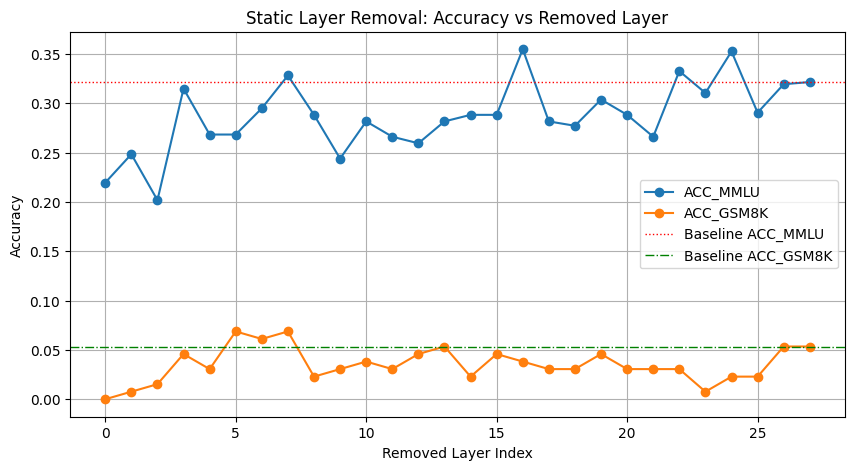

In [17]:
plt.figure(figsize=(10,5))
plt.plot(df_static["layer_idx"], df_static["acc_mmlu"], marker="o", label="ACC_MMLU")
plt.plot(df_static["layer_idx"], df_static["acc_gsm8k"], marker="o", label="ACC_GSM8K")
plt.axhline(baseline_acc_mmlu, color = 'red', linestyle=':', linewidth=1, label="Baseline ACC_MMLU")
plt.axhline(baseline_acc_gsm8k, color = 'green',linestyle='-.', linewidth=1, label="Baseline ACC_GSM8K")
plt.xlabel("Removed Layer Index")
plt.ylabel("Accuracy")
plt.title("Static Layer Removal: Accuracy vs Removed Layer")
plt.legend()
plt.grid()
plt.show()